In [25]:
import numpy as np
import numpy.linalg as la
import pandas as pd
import matplotlib.pyplot as plt
import numpy.random as rand
import datetime
import seaborn as sns
import itertools
import math
import pickle
from statsmodels.tsa.stattools import adfuller
from matplotlib import cm
from scipy.integrate import odeint
from scipy import stats
from EDMtoolkit import *
from modelSystems import *
from EDMtoolkit import *
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.mplot3d import Axes3D
from statsmodels.tsa.stattools import adfuller

%load_ext autoreload
%autoreload 2
# %matplotlib notebook
# plt.rcParams['text.usetex'] = True

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Generate Series from a Linear Model

In [35]:
"""
def generateLinearSeries(length=200,pro_noise=0.0, obs_noise=0.1, theta=lambda t: np.pi/6):
    
    A = lambda theta: np.array([[np.cos(theta),-np.sin(theta)],[np.sin(theta),np.cos(theta)]])
    
    X = np.zeros((length,2))
    init = np.exp(2*np.pi*rand.uniform(0,1)*1j)
    X[0] = (2 ** 0.5) * np.array([init.real, init.imag]) # rand.normal(2)

    for i in range(length-1):
        t = i / (length-1) # if ns else 0
        X[i+1] = (A(theta(t)) @ X[i]) + rand.normal(0,pro_noise,2)
    
    ts = X[:,0] + (rand.normal(0,1,length) * obs_noise)
    
    # return standardize(ts) if ns else standardize(ts)
    return ts # + np.linspace(0,1,num=length) if ns else ts
"""

def generateLinearSeries(length=200, obs_noise=0.1, theta=lambda t: np.pi/6):
    init = rand.random(1) * 2 * np.pi
    
    t = np.linspace(0, 1, num = length)
    ts = np.sin(t * length * theta(t) + init) * np.sqrt(2)
    ts = ts + rand.normal(0, obs_noise, length)

    return ts

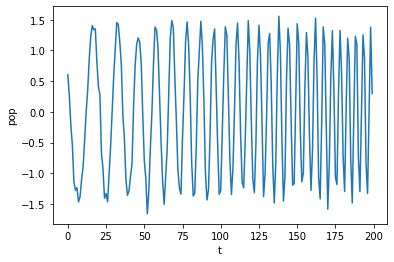

0.9985561251008006

In [36]:
Xr = generateLinearSeries(theta = lambda t: (0.5 + t) * np.pi / 6)
plotTS(Xr)
np.std(Xr)

In [37]:
adfuller(Xr)

(-8.648780040331378,
 5.18321739739844e-14,
 14,
 185,
 {'1%': -3.4662005731940853,
  '5%': -2.8772932777920364,
  '10%': -2.575167750182615},
 78.7737225969621)

In [8]:
# General Hyperparameters
T = 200
o_n = 0.1
N_replicates = 100
reduction = 2 ** 8

In [66]:
# Linear Model NSMap vs DLM
E_max = 5

# ts_std is the standard deviation of the time series which
# is normalized to 1
theta_list = (lambda t: np.pi / 6, lambda t: (0.875 + (t/4)) * np.pi / 6,
              lambda t: (0.5 + t) * np.pi / 6)

# nonstationarity status, delta, theta, r_sqrd, delta_DLM, r_sqrd_DLM
results = np.zeros((N_replicates * 3, 6))
# results = np.zeros((N_replicates * 3, 2))
results_index = 0

for ti, theta in enumerate(theta_list): # [True, False]:
    for i in range(N_replicates):
        Xr = generateLinearSeries(length=T, obs_noise=o_n, theta=theta)
        
        # dftest = adfuller(Xr)
        # results[results_index] = np.array([ti, dftest[1]])
        # results_index += 1
        
        # ax[0, ti].plot(np.linspace(0,1,num=T), Xr)
        # ax[0, ti].set_xticks([])
        # ax[0, ti].set_yticks([])
        
        # delta_agg, theta_agg, r_sqrd = get_delta_agg(Xr, E_max, return_forecast_skill=True, make_plots=True)
        delta_agg, theta_agg, r_sqrd = get_delta_agg(Xr, E_max, return_forecast_skill=True)
        delta_agg_DLM, theta_agg_DLM, r_sqrd_DLM = get_delta_agg(Xr, E_max, return_forecast_skill=True, theta_fixed=True)
        
        results[results_index] = np.array([ti, delta_agg, theta_agg, r_sqrd, delta_agg_DLM, r_sqrd_DLM])
        print(results_index)
        results_index += 1

np.savetxt(f"linear_NSMap_vs_DLM.csv", results, fmt="%0.4f,%0.4f,%0.4f,%0.4f,%0.4f,%0.4f")

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [146]:
print(f"True Stationary Rate = {np.mean(results[results[:,0] == 0, 1] > 0.05)}")
print(f"True Nonstationary Rate = {np.mean(results[results[:,0] == 2, 1] <= 0.05)}")

True Stationary Rate = 0.32
True Nonstationary Rate = 1.0


In [58]:
# Logistic Map NSMap vs DLM
# r_list = (lambda t: 3.75, lambda t: 3.75 - 0.75 * t / T)
# r_list = (lambda t: 3.75 - 0.75 *  t / T,)
r_list = (lambda t: 3.75, lambda t: 3.75 - 0.25 * t / T, lambda t: 3.75 - 0.75 * t / T)
E_max = 5
settlingTime = 200
# log_std is calculated as the standard deviation on a stationary logistic map series with T=200 and r=3.75

# nonstationarity status, delta, theta, r_sqrd, delta_DLM, r_sqrd_DLM
results = np.zeros((N_replicates * len(r_list), 6))
# results = np.zeros((N_replicates * 3, 2))
results_index = 0

for ri, r in enumerate(r_list):
    for i in range(N_replicates):
        x0 = rand.rand(1)
        Xr = standardize(generateTimeSeriesDiscrete("LogisticP", x0, tlen=T, nsargs=(r,), settlingTime=settlingTime))
        Xr += (rand.normal(0,1,T) * o_n)[:,None]
        
        # dftest = adfuller(Xr)
        # results[results_index] = np.array([ri, dftest[1]])
        # results_index += 1
        
        # ax[1, ri].plot(np.linspace(0,1,num=T), Xr)
        # ax[1, ri].set_xticks([])
        # ax[1, ri].set_yticks([])
        
        # print(Xr.flatten())
        # delta_agg, theta_agg, r_sqrd = get_delta_agg(Xr, E_max, return_forecast_skill=True, make_plots=True)
        
        delta_agg, theta_agg, r_sqrd = get_delta_agg(Xr, E_max, return_forecast_skill=True)
        delta_agg_DLM, theta_agg_DLM, r_sqrd_DLM = get_delta_agg(Xr, E_max, return_forecast_skill=True, theta_fixed=True)
        
        results[results_index] = np.array([ri, delta_agg, theta_agg, r_sqrd, delta_agg_DLM, r_sqrd_DLM])
        results_index += 1
        print(results_index)
            
np.savetxt(f"logistic_NSMap_vs_DLM.csv", results, fmt="%0.4f,%0.4f,%0.4f,%0.4f,%0.4f,%0.4f")

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277


In [152]:
print(f"True Stationary Rate = {np.mean(results[results[:,0] == 0, 1] > 0.05)}")
print(f"True Nonstationary Rate = {np.mean(results[results[:,0] == 2, 1] <= 0.05)}")

True Stationary Rate = 0.01
True Nonstationary Rate = 0.6


In [65]:
# Food Chain NSMap vs DLM
end = T * 5
E_max = 5
settlingTime = 2 ** 9
N_replicates = 100

# b1_list = (lambda t: 3, lambda t: 3 + 4 * t / end)
# b1_list = (lambda t: 3 + 4 * t / end,)
b1_list = (lambda t: 3, lambda t: 3 + 2 * t / end, lambda t: 3 + 4 * t / end)

x0 = np.array([0.1,0.4,9]) + rand.random(3)
# log_std is calculated as the standard deviation on a stationary hastings powell map series with T=200 and b1=3
log_std = np.mean(np.array([np.std(generateTimeSeriesContinuous('HastingsPowellP', x0, end=end,
                                          tlen = T, nsargs=(b1_list[0],), 
                                          reduction = reduction, settlingTime=settlingTime, 
                                          process_noise=0)[:,0,None]) for i in range(20)]))

# nonstationarity status, delta, theta, r_sqrd, delta_DLM, r_sqrd_DLM
results = np.zeros((N_replicates * len(b1_list), 6))
# results = np.zeros((N_replicates * 3, 2))
results_index = 0

for b1i, b1 in enumerate(b1_list):
    for i in range(N_replicates):
        x0 = np.array([0.1,0.4,9]) + rand.random(3)
        Xr = generateTimeSeriesContinuous('HastingsPowellP', x0, end=end, tlen = T, nsargs=(b1,), 
                                          reduction = reduction, settlingTime=settlingTime, 
                                          process_noise=0)[:,0,None]
        Xr += (rand.normal(0,1,T) * log_std * o_n)[:,None]
        
        # dftest = adfuller(Xr)
        # results[results_index] = np.array([b1i, dftest[1]])
        # results_index += 1

        # ax[2, ri].plot(np.linspace(0,1,num=T), Xr)
        # ax[2, ri].set_xticks([])
        # ax[2, ri].set_yticks([])

        # delta_agg, theta_agg, r_sqrd = get_delta_agg(Xr, E_max, return_forecast_skill=True, make_plots=True)

        delta_agg, theta_agg, r_sqrd = get_delta_agg(Xr, E_max, return_forecast_skill=True)
        delta_agg_DLM, theta_agg_DLM, r_sqrd_DLM = get_delta_agg(Xr, E_max, return_forecast_skill=True, theta_fixed=True)
        
        results[results_index] = np.array([b1i, delta_agg, theta_agg, r_sqrd, delta_agg_DLM, r_sqrd_DLM])
        results_index += 1
        print(results_index)
        
        # print(delta_agg, delta_agg_DLM)  
np.savetxt(f"food_chain_NSMap_vs_DLM.csv", results, fmt="%0.4f,%0.4f,%0.4f,%0.4f,%0.4f,%0.4f")

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277


In [154]:
print(f"True Stationary Rate = {np.mean(results[results[:,0] == 0, 1] > 0.05)}")
print(f"True Nonstationary Rate = {np.mean(results[results[:,0] == 2, 1] <= 0.05)}")

True Stationary Rate = 0.0
True Nonstationary Rate = 1.0


# NSMap Demonstration Graph

In [38]:
def compute_delta(Xr, maxLags, t=None, horizon=1, tau=1, trainingSteps=100, return_forecast_skill=False, theta_fixed=False, make_plots=False, ax=None):
    
    if t is None:
        t = np.linspace(0,1, num=len(Xr))
    else:
        # Remember to standardize t to be between 0 and 1!
        assert t[0] == 0 and t[-1] == 1

    table = np.zeros((maxLags+1, 5))
    hp = np.zeros(2)

    # produce delay embedding vector first so the set of targets is fixed across all E
    Xemb, Y, tx = delayEmbed(Xr, horizon, maxLags, tau, t=t)

    # for each number of lags from 0 to maxLags
    for l in range(maxLags+1):
        X = Xemb[:,:l+1]

        # print("NSMap")
        thetaNS, deltaNS, lnLNS = optimizeG(X, Y, tx, fixed=np.array([theta_fixed, False]), trainingSteps=trainingSteps, hp=hp.copy())
        # print("SMap")
        thetaS, _, lnLS = optimizeG(X, Y, tx, fixed=np.array([theta_fixed, True]),trainingSteps=trainingSteps, hp=hp.copy())

        table[l] = np.array([deltaNS, lnLNS, lnLS, thetaNS, thetaS])

    lnLdifference = table[:,1] - table[:,2]
    # ns_area =  np.sum(np.maximum(lnLdifference, np.zeros(maxLags+1)))
    delta_agg_weights = np.exp(lnLdifference - np.max(lnLdifference))
    delta_agg = np.average(table[:,0], weights=delta_agg_weights)
    theta = table[np.argsort(table[:,1])[-1],3]
        
    return t, table, delta_agg, theta

In [42]:
E_max = 9
settlingTime = 200

statlin = generateLinearSeries(length = T, obs_noise = o_n, theta = lambda t: np.pi / 6)
nonstatlin = generateLinearSeries(length = T, obs_noise = o_n, theta = lambda t: (0.5 + t) * np.pi / 6) # lambda t: (0.875 + (t/4)) * np.pi / 6)

# lambda t: 3.75, lambda t: 3.75 - 0.25 * t / T, lambda t: 3.75 - 0.75 * t / T

x0 = rand.rand(1)
statlog = standardize(generateTimeSeriesDiscrete("LogisticP", x0, tlen=T, nsargs=(lambda t: 3.75,), settlingTime=settlingTime))
statlog += (rand.normal(0,1,T) * o_n)[:,None]

nonstatlog = standardize(generateTimeSeriesDiscrete("LogisticP", x0, tlen=T, nsargs=(lambda t: 3.75 - 0.75 * t / T,), settlingTime=settlingTime))
nonstatlog += (rand.normal(0,1,T) * o_n)[:,None]

In [43]:
stuff_dict = {}
for i, series in enumerate((statlin, nonstatlin, statlog, nonstatlog)):
    stuff_dict[i] = compute_delta(series, E_max)
    delta, theta, r_sqrd = get_delta_agg(series, E_max, return_forecast_skill=True)
    print(f"delta = {delta}, theta = {theta}, r^2 = {r_sqrd}")

delta = 0.0, theta = 0.0, r^2 = 0.9867591854129792
delta = 40.56331474217962, theta = 0.0, r^2 = 0.9716914496647127
delta = 0.0, theta = 5.249279999999999, r^2 = 0.9722703257140185
delta = 25.26826893311991, theta = 2.8680637900800003, r^2 = 0.9733122121795846


In [46]:
# with open('NSMap_demonstration.pkl', 'wb') as fp:
#     pickle.dump(stuff_dict, fp)

with open('NSMap_demonstration.pkl', 'rb') as fp:
    stuff_dict = pickle.load(fp)
    # print(stuff_dict)

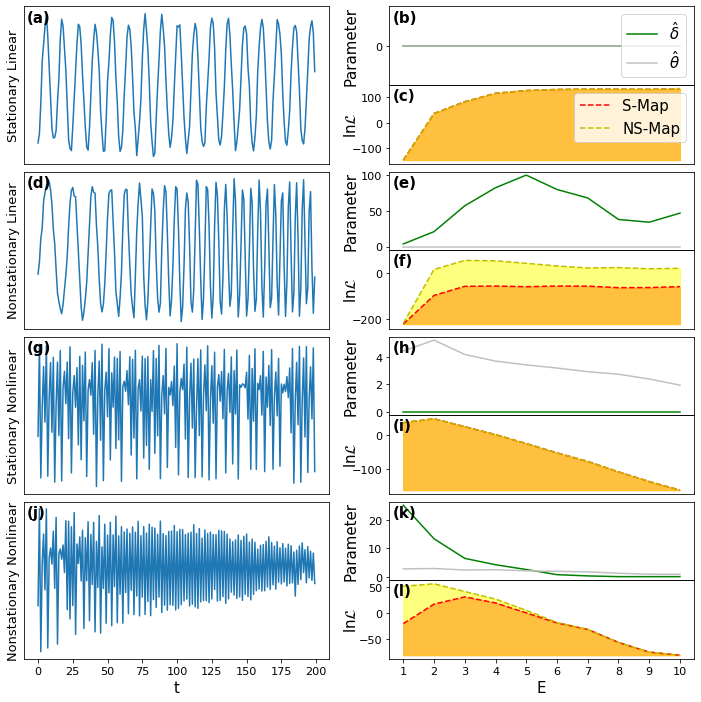

In [51]:
vfig, vax = plt.subplots(4, 2, figsize=(12,12))
maxLags = 9
fsize = 15
text_padding = 0.01
label_pad = -0.15

names = ["Stationary Linear", "Nonstationary Linear", "Stationary Nonlinear", "Nonstationary Nonlinear"]
labelnames = ['(a)','(b)','(c)','(d)','(e)','(f)','(g)','(h)','(i)','(j)','(k)','(l)']

# for series, ax in zip((statlin, nonstatlin, statlog, nonstatlog), vax.flatten()):
for series, ax_row, i in zip((statlin, nonstatlin, statlog, nonstatlog), vax, np.arange(4)):
    E_range = range(1,maxLags+2)
    
    t, table, delta_agg, theta = stuff_dict[i]

    ax_row[0].plot(series)
    ax_row[0].set_yticks([])
    ax_row[0].set_ylabel(names[i], size=fsize-2)
    ax_row[0].tick_params(axis='both', which='major', labelsize=fsize * 3 / 4)
    if i == 3:
        ax_row[0].set_xlabel(r"t", size=fsize)
    else:
        ax_row[0].set_xticks([])
    
    minLine = (table[:,2] * 0)+min(min(table[:,2]),min(table[:,1])) 

    ax_row[1].plot(E_range, table[:,2], "r--", label=r"S-Map")
    ax_row[1].plot(E_range, table[:,1], "y--", label=r"NS-Map")
    ax_row[1].fill_between(E_range, table[:,2], minLine, alpha = 0.5, color="red")
    ax_row[1].fill_between(E_range, table[:,1], minLine, alpha = 0.5, color = "yellow")
    # ax_row[1].set_ylabel(r"$\ln\mathcal{L}$", size = fsize, rotation=90, labelpad = 20)
    ax_row[1].set_xticks(E_range)
    if i != 3:
        ax_row[1].set_xticks([])
    else:
        ax_row[1].set_xlabel("E", size = fsize)
    if i == 1:
        ax_row[1].set_ylim([minLine[0]-20, 100])
    ax_row[1].tick_params(axis='both', which='major', labelsize=fsize * 3 / 4)
    
    divider = make_axes_locatable(ax_row[1])
    bax = divider.append_axes('top', size='100%', pad=0)
    
    bax.plot(E_range, table[:,0], label=r"$\hat{\delta}$", color="green")
    bax.plot(E_range, table[:,3], label=r"$\hat{\theta}$", color="silver")
    bax.set_xticks([])
    # bax.set_ylabel(r"Param Value", size = fsize, rotation=90, labelpad = 20)
    bax.tick_params(axis='both', which='major', labelsize=fsize * 3 / 4)
    
    ax_row[0].text(text_padding, 1-text_padding*2, f"{labelnames[3*i]}", size=fsize, fontweight="bold",
           horizontalalignment="left", verticalalignment="top",
           transform=ax_row[0].transAxes)
    bax.text(text_padding, 1-text_padding*4, f"{labelnames[3*i+1]}", size=fsize,fontweight="bold",
           horizontalalignment="left",verticalalignment="top",
           transform=bax.transAxes)
    bax.text(label_pad, 0.5, r"Parameter", size=fsize,
           horizontalalignment="left", verticalalignment="center", rotation = 90,
           transform=bax.transAxes)
    ax_row[1].text(text_padding, 1-text_padding*4, f"{labelnames[3*i+2]}", size=fsize, fontweight="bold",
           horizontalalignment="left",verticalalignment="top",
           transform=ax_row[1].transAxes)
    ax_row[1].text(label_pad, 0.5, r"$\ln\mathcal{L}$", size=fsize, rotation = 90, 
           horizontalalignment="left",verticalalignment="center",
           transform=ax_row[1].transAxes)
    
    if i == 0:
        bax.legend(fontsize = fsize)
        bax.set_yticks([0])
        ax_row[1].legend(fontsize = fsize)
        
# plt.tight_layout()
plt.subplots_adjust(wspace=0.2,
                    hspace=0.05)
# plt.show()
# plt.savefig("../Figures/NSMap_demonstration2.png")
plt.savefig(f"../PDF_figures_tables/NSMap_demonstration.pdf", format="pdf", bbox_inches="tight")
# plt.show()

# Delta vs Theta graph

In [3]:
# fill with data of results for Hastings Powell and Logistic in Round 2
# l_data = np.loadtxt("simulation_results_final\logistic_NSMap_vs_DLM.csv",delimiter=',')
# hp_data = np.loadtxt("simulation_results_final\hastings_powell_NSMap_vs_DLM.csv",delimiter=',')
# lin_data = np.loadtxt("simulation_results_final\linear_NSMap_vs_DLM.csv",delimiter=',')
l_data = np.loadtxt("logistic_NSMap_vs_DLM.csv",delimiter=',')
hp_data = np.loadtxt("food_chain_NSMap_vs_DLM.csv",delimiter=',')
lin_data = np.loadtxt("linear_NSMap_vs_DLM.csv",delimiter=',')

l_nonstat = np.log(l_data[l_data[:,0] == 2][:,1:3]+1)
l_stat = np.log(l_data[l_data[:,0] == 0][:,1:3]+1)
hp_nonstat = np.log(hp_data[hp_data[:,0] == 2][:,1:3]+1)
hp_stat = np.log(hp_data[hp_data[:,0] == 0][:,1:3]+1)
lin_nonstat = np.log(lin_data[lin_data[:,0] == 2][:,1:3]+1)
lin_stat = np.log(lin_data[lin_data[:,0] == 0][:,1:3]+1)

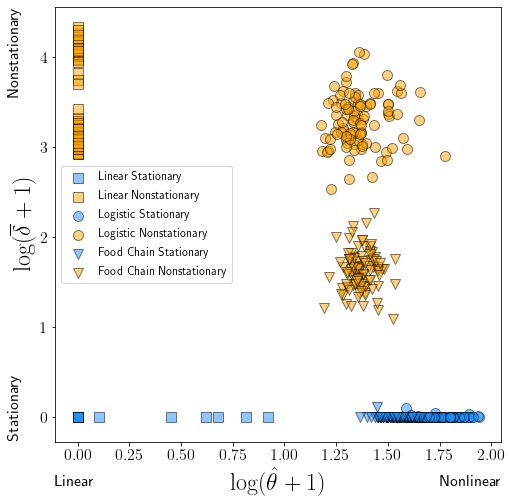

In [5]:
size = 100
alpha = 0.5
dither = 0.02
fontsize_ticks = 16
fontsize_legend = 12
fontsize_axis = 24
fontsize_text = 16
text_padding = -0.075

dithering = lambda: rand.normal(0,dither,size=size)

dvt_fig, dvt_ax = plt.subplots(1, figsize=(8,8))
dvt_ax.set_xlabel(r"$\log(\hat{\theta}+1)$",fontsize=fontsize_axis)
dvt_ax.set_ylabel(r"$\log(\overline{\delta}+1)$",fontsize=fontsize_axis)
# dvt_ax.set_xticks([0,1.75])
dvt_ax.text(text_padding, 1, "Nonstationary", size=fontsize_text, rotation=90, 
            horizontalalignment="right", verticalalignment="top",
            transform=dvt_ax.transAxes)
dvt_ax.text(text_padding, 0, "Stationary", size=fontsize_text, rotation=90,
           horizontalalignment="right",verticalalignment="bottom",
           transform=dvt_ax.transAxes)
dvt_ax.text(0, text_padding, "Linear", size=fontsize_text,
           horizontalalignment="left",verticalalignment="top",
           transform=dvt_ax.transAxes)
dvt_ax.text(1, text_padding, "Nonlinear", size=fontsize_text,
           horizontalalignment="right",verticalalignment="top",
           transform=dvt_ax.transAxes)

dvt_ax.scatter(lin_stat[:,1], lin_stat[:,0], 
               c="dodgerblue",marker="s", s=size, edgecolors="black", 
               label="Linear Stationary", alpha=alpha)
dvt_ax.scatter(lin_nonstat[:,1], lin_nonstat[:,0], 
               c="orange",marker="s", s=size, edgecolors="black", 
               label="Linear Nonstationary", alpha=alpha)
dvt_ax.scatter(l_stat[:,1], l_stat[:,0], 
               c="dodgerblue", s=size, edgecolors="black", 
               label="Logistic Stationary", alpha=alpha)
dvt_ax.scatter(l_nonstat[:,1], l_nonstat[:,0], 
               c="orange", s=size, edgecolors="black", 
               label="Logistic Nonstationary", alpha=alpha)
dvt_ax.scatter(hp_stat[:,1], hp_stat[:,0], 
               c="dodgerblue",marker="v", s=size, edgecolors="black", 
               label="Food Chain Stationary", alpha=alpha)
dvt_ax.scatter(hp_nonstat[:,1], hp_nonstat[:,0], 
               c="orange",marker="v", s=size, edgecolors="black", 
               label="Food Chain Nonstationary", alpha=alpha)

plt.xticks(fontsize=fontsize_ticks, rotation=0)
plt.yticks(fontsize=fontsize_ticks, rotation=0)
plt.legend(prop={"size":fontsize_legend})
# plt.savefig("../Figures/round1_delta_theta.png",dpi=300)
plt.savefig(f"../PDF_figures_tables/round1_results/round1_delta_theta.pdf", format="pdf", bbox_inches="tight")

In [84]:
# DLM Version

"""
for model in ["l", "hp", "lin"]:
    t1 = locals()[model+"_data"]
    for status in ["stat","nonstat"]:
        t2 = t1[t1[:,0] == (status == "nonstat")]
        for appr in ["DLM", "NS"]:
            t3 = [t2[:,1:4:2] if appr == "NS" else t2[:,4:]][0]
            locals()[model+"_"+status+"_"+appr] = t3
"""

## NSMap vs DLM

In [6]:
lin_data = np.loadtxt("linear_NSMap_vs_DLM.csv",delimiter=',')
l_data = np.loadtxt("logistic_NSMap_vs_DLM.csv",delimiter=',')
fc_data = np.loadtxt("food_chain_NSMap_vs_DLM.csv",delimiter=',')

DLM lin none 1.0
NSMap lin none 1.0
DLM lin fast 1.0
NSMap lin fast 1.0
DLM l none 0.66
NSMap l none 0.99
DLM l fast 0.92
NSMap l fast 1.0
DLM fc none 1.0
NSMap fc none 0.99
DLM fc fast 0.76
NSMap fc fast 1.0


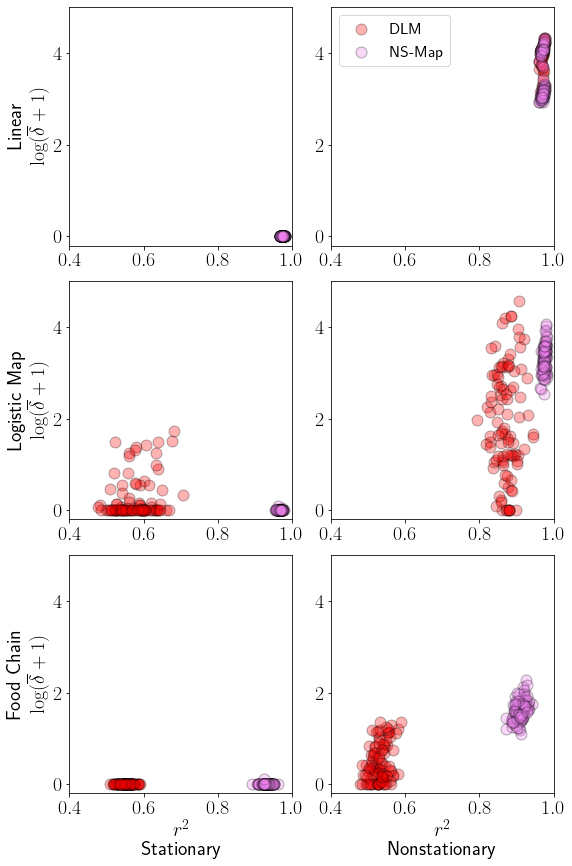

In [7]:
vfig, vax = plt.subplots(3,2,figsize=(8,12))
B=40
size = 120
fontsize_axis = 20
fontsize_ticks = 20
fontsize_text = 20

text_padding_y = -0.2
text_padding_x = -0.2

dithering = lambda : rand.normal(0,0.05,100)

for m, model in enumerate(["lin", "l", "fc"]):
    data = locals()[model + "_" + "data"]
    for s, status in zip([0,2],["none", "fast"]):
        datap = data[data[:,0] == s]
        vax[m,min(1,s)].scatter(datap[:,5], np.log(datap[:,4]+1),
                         color="red",s=size, 
                         edgecolors="black",
                         alpha=0.3,label="DLM")
        vax[m,min(1,s)].scatter(datap[:,3], np.log(datap[:,1]+1),
                         color="violet",s=size, 
                         edgecolors="black",
                         alpha=0.3,label="NS-Map")

        vax[m,min(1,s)].set_xlim([0.4,1])
        vax[m,min(1,s)].set_ylim([-0.2,5])
        vax[m,min(1,s)].tick_params(axis='both',which='major',
                             labelsize=fontsize_ticks)
        
        if s == 0:
            print(f"DLM {model} {status} {np.mean(datap[:,4] <= 0.1)}")
            print(f"NSMap {model} {status} {np.mean(datap[:,1] <= 0.1)}")
        else:
            print(f"DLM {model} {status} {np.mean(datap[:,4] > 0.1)}")
            print(f"NSMap {model} {status} {np.mean(datap[:,1] > 0.1)}")
        

for i in range(3):
    vax[i,0].set_ylabel(r"$\log(\overline{\delta}+1)$",size=fontsize_axis)
for i in range(2):
    vax[2,i].set_xlabel(r"$r^2$",size=fontsize_axis)


vax[0,0].text(text_padding_y, 0.5, "Linear", rotation=90,
              verticalalignment="center", horizontalalignment="right",
              transform=vax[0,0].transAxes,size=fontsize_text)
vax[1,0].text(text_padding_y, 0.5, "Logistic Map", rotation=90,
              verticalalignment="center", horizontalalignment="right",
              transform=vax[1,0].transAxes,size=fontsize_text)
vax[2,0].text(text_padding_y, 0.5, "Food Chain", rotation=90,
              verticalalignment="center", horizontalalignment="right",
              transform=vax[2,0].transAxes,size=fontsize_text)
vax[2,0].text(0.5, text_padding_x, "Stationary",
              verticalalignment="top", horizontalalignment="center",
              transform=vax[2,0].transAxes,size=fontsize_text)
vax[2,1].text(0.5, text_padding_x, "Nonstationary", 
              verticalalignment="top", horizontalalignment="center",
              transform=vax[2,1].transAxes,size=fontsize_text)
# vax[2,2].text(0.5, text_padding_x, "Fast Nonstationary", 
#               verticalalignment="top", horizontalalignment="center",
#               transform=vax[2,2].transAxes,size=fontsize_text)

vax[0,1].legend(fontsize=16)
plt.tight_layout()
# plt.savefig("../Figures/round1_NSMap_vs_DLM.png", dpi=300)
plt.savefig("../PDF_figures_tables/round1_NSMap_vs_DLM.pdf", format="pdf", bbox_inches="tight")

In [87]:
# Compute the increase in forecast skill for nonlinear models from SMap to NSMap,
# averaging over all nonstationary categories

print(f"Logistic NSMap r_sqrd = {np.mean(l_data[:,3])}")
print(f"Logistic SMap r_sqrd = {np.mean(l_data[:,5])}")
print(f"Food Chain NSMap r_sqrd = {np.mean(fc_data[:,3])}")
print(f"Food Chain SMap r_sqrd = {np.mean(fc_data[:,5])}")

Logistic NSMap r_sqrd = 0.9701930000000001
Logistic SMap r_sqrd = 0.7415623333333333
Food Chain NSMap r_sqrd = 0.9172643333333333
Food Chain SMap r_sqrd = 0.5320163333333333


# Supplement Figure

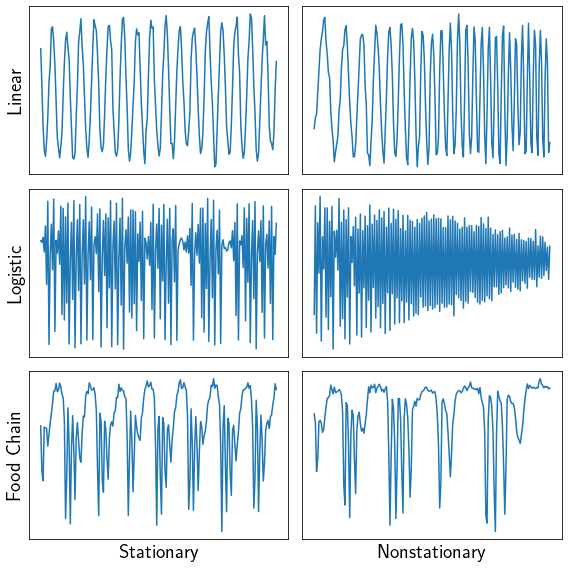

In [90]:
fig, ax = plt.subplots(3,2,figsize=(8,8), tight_layout=True)

# Linear Model NSMap vs DLM
E_max = 2

# ts_std is the standard deviation of the time series which
# is normalized to 1
log_std = 1
# theta_list = (lambda t: np.pi / 6, lambda t: (0.875 + (t/4)) * np.pi / 6, lambda t: (0.5 + t) * np.pi / 6)
theta_list = (lambda t: np.pi / 6, lambda t: (0.5 + t) * np.pi / 6)

for ti, theta in enumerate(theta_list):
    Xr = generateLinearSeries(length=T, obs_noise=o_n, theta=theta)
    Xr += (rand.normal(0,1,T) * log_std * o_n)
        
    ax[0, ti].plot(np.linspace(0,1,num=T), Xr)
    ax[0, ti].set_xticks([])
    ax[0, ti].set_yticks([])
        
# r_list = (lambda t: 3.75, lambda t: 3.75 - 0.25 * t / T, lambda t: 3.75 - 0.75 * t / T)
r_list = (lambda t: 3.75, lambda t: 3.75 - 0.75 * t / T)
settlingTime = 200

for ri, r in enumerate(r_list):
    x0 = rand.rand(1)
    Xr = standardize(generateTimeSeriesDiscrete("LogisticP", x0, tlen=T, nsargs=(r,), settlingTime=settlingTime))
    Xr += (rand.normal(0,1,T) * o_n)[:,None]
        
    ax[1, ri].plot(np.linspace(0,1,num=T), Xr)
    ax[1, ri].set_xticks([])
    ax[1, ri].set_yticks([])

end = T * 5
E_max = 4
settlingTime = 2 ** 9
# b1_list = (lambda t: 3, lambda t: 3 + 2 * t / end, lambda t: 3 + 4 * t / end)
b1_list = (lambda t: 3, lambda t: 3 + 4 * t / end)

x0 = np.array([0.1,0.4,9]) + rand.random(3)
# log_std is calculated as the standard deviation on a stationary hastings powell map series with T=200 and b1=3
log_std = np.mean(np.array([np.std(generateTimeSeriesContinuous('HastingsPowellP', x0, end=end,
                                          tlen = T, nsargs=(b1_list[0],), 
                                          reduction = reduction, settlingTime=settlingTime, 
                                          process_noise=0)[:,0,None]) for i in range(20)]))

for b1i, b1 in enumerate(b1_list):
    x0 = np.array([0.1,0.4,9]) + rand.random(3)
    Xr = generateTimeSeriesContinuous('HastingsPowellP', x0, end=end, tlen = T, nsargs=(b1,), 
                                      reduction = reduction, settlingTime=settlingTime, 
                                      process_noise=0)[:,0,None]
    Xr += (rand.normal(0,1,T) * log_std * o_n)[:,None]

    ax[2, b1i].plot(np.linspace(0,1,num=T), Xr)
    ax[2, b1i].set_xticks([])
    ax[2, b1i].set_yticks([])
    
# ns_status = ["No Change", "Slow Change", "Fast Change"]
ns_status = ["Stationary", "Nonstationary"]
    
for i in range(3):
    ax[i,0].set_ylabel(r"{}".format(["Linear", "Logistic", "Food Chain"][i]), rotation=90,
                     fontsize=20)
# for i in range(3):
#     ax[2,i].set_xlabel(r"{}".format(ns_status[i]), fontsize=20)
for i in range(2):
    ax[2,i].set_xlabel(r"{}".format(ns_status[i]), fontsize=20)
# plt.savefig("../Figures/simulation_series_supplement/round1_series.png", dpi=300)
plt.savefig("../PDF_figures_tables/round1_series.pdf", format="pdf", bbox_inches="tight")